## **Loading datasets from kaggle**

In [0]:
from google.colab import drive
drive.mount('/content/drive')

!cp '/content/drive/My Drive/kaggle.json' ./

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!kaggle competitions download -c statoil-iceberg-classifier-challenge

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
  0% 0.00/37.7k [00:00<?, ?B/s]
100% 37.7k/37.7k [00:00<00:00, 66.4MB/s]
 89% 38.0M/42.9M [00:00<00:00, 147MB/s]
100% 42.9M/42.9M [00:00<00:00, 170MB/s]
 99% 242M/245M [00:01<00:00, 130MB/s]
100% 245M/245M [00:01<00:00, 158MB/s]


# Unzip 7z files 

In [0]:
!7z e train.json.7z


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 44932785 bytes (43 MiB)

Extracting archive: train.json.7z
--
Path = train.json.7z
Type = 7z
Physical Size = 44932785
Headers Size = 154
Method = LZMA2:24
Solid = -
Blocks = 1

  0%      6% - data/processed/train.json                                 12% - data/processed/train.json                                 19% - data/processed/train.json                                 27% - data/processed/train.json                                 35% - data/processe

In [0]:
!7z e test.json.7z


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 257127394 bytes (246 MiB)

Extracting archive: test.json.7z
--
Path = test.json.7z
Type = 7z
Physical Size = 257127394
Headers Size = 154
Method = LZMA2:24
Solid = -
Blocks = 1

  0%      1% - data/processed/test.json                                 2% - data/processed/test.json                                 3% - data/processed/test.json                                 5% - data/processed/test.json                                 6% - data/processed/test.json

In [0]:
import pandas as pd

# **Load Training & Test Data**

In [0]:
train = pd.read_json("train.json")

**Columns in the dataset**

id - the id of the image

band_1, band_2 - the flattened image data. Each band has 75x75 pixel values in the list. Band 1 and Band 2 are signals characterized by radar backscatter produced from different polarizations at a particular incidence angle. The polarizations correspond to HH (transmit/receive horizontally) and HV (transmit horizontally and receive vertically).

inc_angle - the incidence angle of which the image was taken. 

is_iceberg - the target variable, set to 1 if it is an iceberg, and 0 if it is a ship. 

In [0]:
test = pd.read_json("test.json")

In [0]:
import numpy as np 
import cv2 # Used to manipulated the images 
np.random.seed(1337) # The seed I used - pick your own or comment out for a random seed. A constant seed allows for better comparisons though
import matplotlib.pyplot as plt

# Import Keras 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam

Using TensorFlow backend.


### **Visualizations**

This shows the number of individual satellite images of ships and icebergs


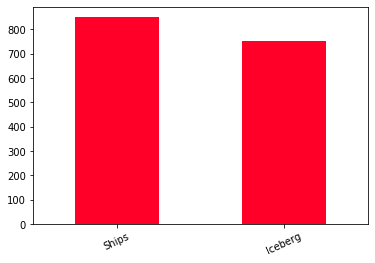

In [0]:
iceberg_ship_count = train['is_iceberg'].value_counts()
iceberg_ship_count1=iceberg_ship_count.plot(kind='bar',colormap='gist_rainbow')
plt.xticks(rotation=25)
iceberg_ship_count1.set_xticklabels( ('Ships', 'Iceberg') )
plt.show()


**Reshape and feature scale the images:**

Sentinal Settalite only Transmit pings in Horizontal polarization, AND NOT IN Vertical polarization. Those H-pings gets scattered, objects change their polarization and returns as a mix of H  and V. Since Sentinel has only H-transmitter, return signals are of the form of HH and HV only.
 
 Here the  two bands are extracted  and their avg is taken to create a 3-channel RGB equivalent.

In [0]:
def get_scaled_imgs(df):
    imgs = []
    
    for i, row in df.iterrows():
        #make 75x75 image
        band_1 = np.array(row['band_1']).reshape(75, 75)
        band_2 = np.array(row['band_2']).reshape(75, 75)
        band_3 = band_1 + band_2 # plus since log(x*y) = log(x) + log(y)
        
        # Rescale
        a = (band_1 - band_1.mean()) / (band_1.max() - band_1.min())
        b = (band_2 - band_2.mean()) / (band_2.max() - band_2.min())
        c = (band_3 - band_3.mean()) / (band_3.max() - band_3.min())

        imgs.append(np.dstack((a, b, c)))

    return np.array(imgs)

In [0]:
Xtrain = get_scaled_imgs(train)

In [0]:
Ytrain = np.array(train['is_iceberg'])

Some of the incident angles from the satellite are unknown and marked as "na". Replace these na with 0 and find the indices where the incident angle is >0 (this way you can use a truncated set or the full set of training data).

In [0]:
train.inc_angle = train.inc_angle.replace('na',0)
idx_tr = np.where(train.inc_angle>0)

We can now use the option of training with only known incident angles or the whole set.

In [0]:
Ytrain = Ytrain[idx_tr[0]]
Xtrain = Xtrain[idx_tr[0],...]

## **Adding images for training**

To increase the number of images to increase the accuracy , we simply flipped the present images horizontally or vertically. 

In [0]:
def get_more_images(imgs):
    
    more_images = []
    vert_flip_imgs = []
    hori_flip_imgs = []
      
    for i in range(0,imgs.shape[0]):
        a=imgs[i,:,:,0]
        b=imgs[i,:,:,1]
        c=imgs[i,:,:,2]
        
        av=cv2.flip(a,1)
        ah=cv2.flip(a,0)
        bv=cv2.flip(b,1)
        bh=cv2.flip(b,0)
        cv=cv2.flip(c,1)
        ch=cv2.flip(c,0)
        
        vert_flip_imgs.append(np.dstack((av, bv, cv)))
        hori_flip_imgs.append(np.dstack((ah, bh, ch)))
      
    v = np.array(vert_flip_imgs)
    h = np.array(hori_flip_imgs)
       
    more_images = np.concatenate((imgs,v,h))
    
    return more_images


In [0]:
Xtr_more = get_more_images(Xtrain) 

In [0]:
Ytr_more = np.concatenate((Ytrain,Ytrain,Ytrain))

## **CNN Keras Model**

I used a convolutional layer followed by a maxpooling layer along with 20% dropout in between to reduce overfitting.

I repeated the same for four stacks for better generalization of results.

The last layer is a dense layer with sigmoid as the activation function.

Finally I have used Adam as the optimizer and binary cross entropy is used as the loss function.


In [0]:
def getModel():
    #Build keras model
    
    model=Sequential()
    
    # CNN 1
    model.add(Conv2D(64, kernel_size=(3, 3),activation='relu', input_shape=(75, 75, 3)))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(Dropout(0.2))

    # CNN 2
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu' ))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.2))

    # CNN 3
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.2))

    #CNN 4
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.2))

    # You must flatten the data for the dense layers
    model.add(Flatten())

    #Dense 1
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))

    #Dense 2
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))

    # Output 
    model.add(Dense(1, activation="sigmoid"))

    optimizer = Adam(lr=0.001, decay=0.0)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

ModelCheckpoint: when training requires a lot of time to achieve a good result, often many iterations are required. In this case, it is better to save a copy of the best performing model only when an epoch that improves the metrics ends.

EarlyStopping: sometimes, during training we can notice that the generalization gap (i.e. the difference between training and validation error) starts to increase, instead of decreasing. Often, a practical and efficient solution is to stop training when the generalization gap is getting worse.


In [0]:
model = getModel()
model.summary()

batch_size = 32
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 73, 73, 64)        1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
____________________________________

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1335: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


# Train the model

In [0]:
model_history = model.fit(Xtr_more, Ytr_more, batch_size=batch_size, epochs=50, verbose=1, callbacks=[earlyStopping, mcp_save, reduce_lr_loss], validation_split=0.25)




Train on 3309 samples, validate on 1104 samples
Epoch 1/50





3309/3309 [==============================] - 16s 5ms/step - loss: 0.5479 - acc: 0.7138 - val_loss: 0.4275 - val_acc: 0.8025
Epoch 2/50
3309/3309 [==============================] - 2s 526us/step - loss: 0.3810 - acc: 0.8211 - val_loss: 0.3553 - val_acc: 0.8406
Epoch 3/50
3309/3309 [==============================] - 2s 530us/step - loss: 0.3345 - acc: 0.8525 - val_loss: 0.3085 - val_acc: 0.8940
Epoch 4/50
3309/3309 [==============================] - 2s 526us/step - loss: 0.2794 - acc: 0.8707 - val_loss: 0.2740 - val_acc: 0.8986
Epoch 5/50
3309/3309 [==============================] - 2s 533us/step - loss: 0.2417 - acc: 0.8982 - val_loss: 0.2982 - val_acc: 0.8777
Epoch 6/50
3309/3309 [==============================] - 2s 530us/step - loss: 0.2301 - acc: 0.9042 - val_loss: 0.2248 - val_acc: 0.9185
Epoch 7/50
3309/3309 [==============================] - 2s 531us/step - loss: 0.2061 - acc: 0.9118 - val_loss: 0.2310 - val_acc: 

In [0]:
from matplotlib import pyplot as plt

def plot_training_metrics(history_object, metric = 'loss', val = True):
    
    plt.plot(history_object.history[metric])
    
    if val == True:
        plt.plot(history_object.history['val_' + metric])
    
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

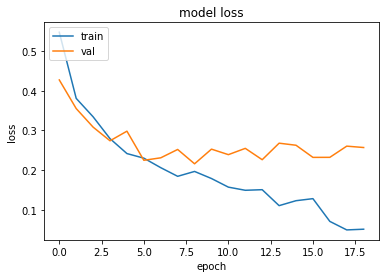

In [0]:
plot_training_metrics(model_history)

### **Results**

Load the best weights and check the score on the training data.

In [0]:
model.load_weights('mdl_wts.hdf5')

score = model.evaluate(Xtrain, Ytrain, verbose=1)
print('Train score:', score[0])
print('Train accuracy:', score[1])


1471/1471 [==============================] - 0s 283us/step
Train score: 0.13264368183753833
Train accuracy: 0.95581237253569


Predict the model on test data and generate output file for submission

In [0]:
test.inc_angle = test.inc_angle.replace('na',0)
Xtest = (get_scaled_imgs(test))
pred_test = model.predict(Xtest)

submission = pd.DataFrame({'id': test["id"], 'is_iceberg': pred_test.reshape((pred_test.shape[0]))})
print(submission.head(10))

submission.to_csv('submission.csv', index=False)

         id    is_iceberg
0  5941774d  1.353131e-01
1  4023181e  9.255884e-01
2  b20200e4  9.710193e-03
3  e7f018bb  9.996057e-01
4  4371c8c3  9.524671e-01
5  a8d9b1fd  2.037888e-01
6  29e7727e  6.540915e-02
7  92a51ffb  9.997040e-01
8  c769ac97  4.440546e-06
9  aee0547d  5.662441e-07
